In [2]:
import nibabel as nb
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [3]:
nsddata_path = '/mnt/f_disk/tarak/nsd_data_dump/nsddata'
nsdbeta_path = '/mnt/f_disk/tarak/nsd_data_dump/nsddata_betas/ppdata'

# For subject 1

In [4]:
## fit hrf
mgh_file = nb.load(nsdbeta_path + '/subj01/fsaverage/betas_fithrf_GLMdenoise_RR/lh.betas_session01.mgh')
data = mgh_file.get_fdata()

In [5]:
data.shape 
# The size of the data indicates that we have 163842 vertices in the 4D domain (which has been projected onto a 2D mesh) and the next 2 1's 
# are just dummy variables kept to maintain the 4D nature of the surface. 750 represents the number of time points in the session. 

(163842, 1, 1, 750)

In [6]:
data = data.squeeze() 
data.shape

(163842, 750)

In [7]:
mean_data = np.mean(data, axis=1)  # Shape: (163842,) # Averaging over all time points 
time_point_data = data[0, :]  # Shape: (163842,) # data of a single voxel across all 750 time points
mean_data = np.asarray(mean_data)

In [8]:
np.mean(mean_data)

0.25192190457835817

In [9]:
print(mean_data.shape)
print(time_point_data.shape)

(163842,)
(750,)


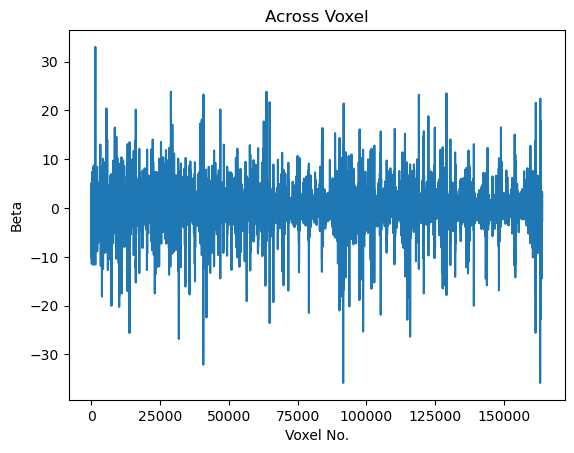

In [10]:
plt.plot(data[: , 0]) # All voxels at a single point in time
# plt.plot(data[: , 1])
# plt.plot(data[: , 2])
plt.title("Across Voxel")
plt.xlabel("Voxel No.")
plt.ylabel("Beta")
plt.show()

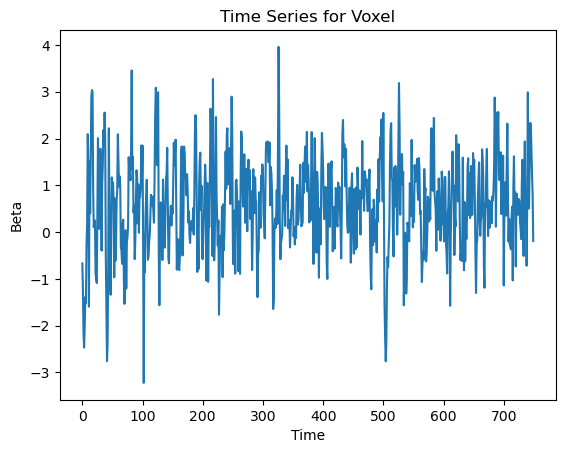

In [11]:
plt.plot(time_point_data)
# plt.plot(data[600, :])
plt.title("Time Series for Voxel")
plt.xlabel("Time")
plt.ylabel("Beta")
plt.show()

In [12]:
data.shape

(163842, 750)

In [13]:
beta_var = np.var(data, axis=1, ddof=0)
beta_var.shape

(163842,)

In [14]:
min_var = np.min(beta_var)
max_var = np.max(beta_var)
print("min_variance", min_var, "max_variance", max_var)

min_variance 0.10005700159097641 max_variance 217.81720367665852


In [15]:
print(min_var)
print(max_var)

0.10005700159097641
217.81720367665852


In [16]:
threshold = 0.01 * max_var
filtered_data = data[beta_var > threshold]
print(filtered_data.shape)

(26757, 750)


In [18]:
# plt.figure(figsize=(6, 6))
# plt.imshow(images[0])
# plt.axis('off')
# plt.title("Image1")
# plt.show()

In [16]:
# if dataset is not None:
#     plt.figure(figsize=(20, 10))
#     for i in range(20):
#         image = images[i]
#         plt.subplot(4, 5, i + 1)
#         plt.imshow(image)
#         plt.axis('off')
#         plt.title(f"Image {i+1}")
#     plt.tight_layout()
#     plt.show()
# else:
#     print("Unable to load dataset.")

In [41]:
import pandas as pd

stim_info = pd.read_csv('/mnt/f_disk/tarak/nsd_data_dump/nsddata/experiments/nsd/nsd_stim_info_merged.csv')
stim_info.head()

Unnamed: 0  cocoId cocoSplit                         cropBox      loss  \
0           0  532481   val2017    (0, 0, 0.1671875, 0.1671875)  0.100000   
1           1  245764   val2017            (0, 0, 0.125, 0.125)  0.000000   
2           2  385029   val2017            (0, 0, 0.125, 0.125)  0.000000   
3           3  311303   val2017  (0, 0, 0.16640625, 0.16640625)  0.125000   
4           4  393226   val2017            (0, 0, 0.125, 0.125)  0.133333   

   nsdId  flagged  BOLD5000  shared1000  subject1  ...  subject5_rep2  \
0      0    False     False       False         0  ...              0   
1      1    False     False       False         0  ...              0   
2      2    False     False       False         0  ...              0   
3      3    False     False       False         0  ...              0   
4      4    False     False       False         0  ...              0   

   subject6_rep0  subject6_rep1  subject6_rep2  subject7_rep0  subject7_rep1  \
0              0              0              0              0              0   
1              0              0              0          13985          14176   
2              0              0              0              0              0   
3              0              0              0              0              0   
4          13720          22861          23023              0              0   

   subject7_rep2  subject8_rep0  subject8_rep1  subject8_rep2  
0              0              0              0              0  
1          28603              0              0              0  
2              0              0              0              0  
3              0              0              0              0  
4              0              0              0              0  

[5 rows x 41 columns]

In [20]:
stim_info['subject1_rep0']

0            0
1            0
2            0
3            0
4            0
         ...  
72995        0
72996        0
72997        0
72998        0
72999    16206
Name: subject1_rep0, Length: 73000, dtype: int64

In [42]:
print(stim_info.shape)

(73000, 41)


In [21]:
np.min(np.array(stim_info['cocoId']))

9

In [22]:
filtered_data.shape

(26757, 750)

In [23]:
from sklearn.decomposition import FastICA
from sklearn.metrics.pairwise import cosine_similarity

In [24]:
from sklearn.metrics import mean_squared_error
def do_ica(X, n_components=10):
    Xt = X - np.mean(X, axis=0)
    ica = FastICA(n_components=n_components, random_state=0)
    S_ = ica.fit_transform(Xt)
    A_ = ica.mixing_           # Mixing matrix
    reconstructed_X = np.dot(S_, A_.T) + np.mean(X, axis=0)
    return S_.T, reconstructed_X

def compute_reconstruction_error(original, reconstructed):
    return mean_squared_error(original, reconstructed)

In [25]:
ics, reconstructed_data = do_ica(data, n_components=100)

In [26]:
reconstruction_error = compute_reconstruction_error(data, reconstructed_data)

In [27]:
reconstruction_error

0.9591989449778405

In [30]:
print(filtered_data.shape)
b = filtered_data.T
b.shape

(26757, 750)


(750, 26757)

In [31]:
def do_ica(X, n_components=10):
    X = X - np.mean(X, axis=0)
    Xt = X
    ica = FastICA(n_components=n_components, random_state=0)
    S_ = ica.fit_transform(Xt)
    ics = S_.T
    cosine_sim = cosine_similarity(ics, X.T)
    return ics, cosine_sim

In [32]:
ics, cosine_sim = do_ica(filtered_data, n_components=10)

In [33]:
ics.shape

(10, 26757)

In [36]:
np.max(cosine_sim)

0.6747857044456125

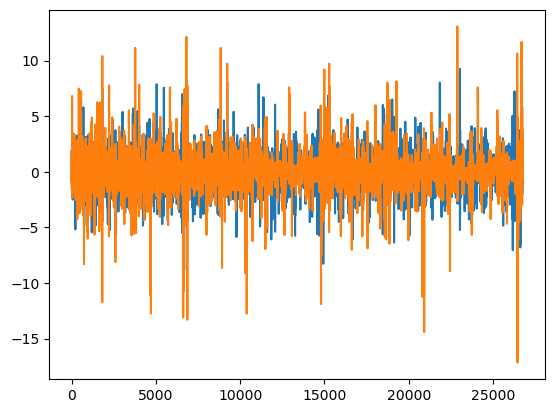

In [37]:
plt.plot(ics[0, :])
plt.plot(ics[1, :])
# plt.plot(ics[2, :])
# plt.plot(ics[3, :])
# plt.plot(ics[4, :])
# plt.plot(ics[5, :])
# plt.plot(ics[6, :])
# plt.plot(ics[7, :])
# plt.plot(ics[8, :])
# plt.plot(ics[9, :])
plt.show()

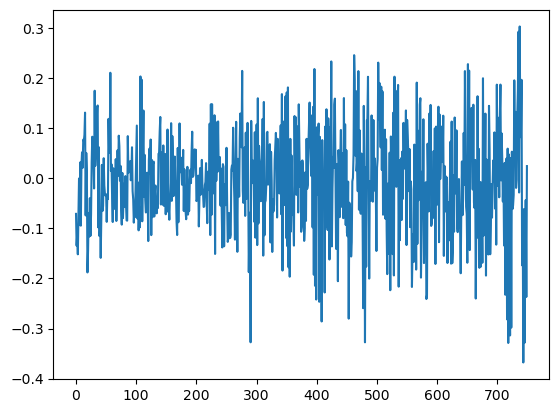

In [25]:
plt.plot(cosine_sim[1, :])
# plt.plot(cosine_sim[1, :])
# plt.plot(cosine_sim[2, :])
# plt.plot(cosine_sim[3, :])
# plt.plot(cosine_sim[4, :])
# plt.plot(cosine_sim[7, :])
plt.show()

In [43]:
subj1_inds = np.full(30000, -1)
for _, row in stim_info.iterrows():
    id_val = row['nsdId']
    for col in ['subject1_rep0', 'subject1_rep1', 'subject1_rep2']:
        index = row[col]
        if index != 0:
            subj1_inds[index - 1] = id_val

In [27]:
cosine_sim.shape

(10, 750)

In [45]:
subj1_session1_inds = subj1_inds[:750]

In [46]:
selected_images = []
with h5py.File('/mnt/f_disk/tarak/nsd_data_dump/nsd_stimuli.hdf5', 'r') as hdf:
    print("Keys:", list(hdf.keys()))
    dataset = hdf['imgBrick']
    print("Dataset shape:", dataset.shape)
    selected_images = np.array([dataset[i] for i in subj1_session1_inds])

Keys: ['imgBrick']
Dataset shape: (73000, 425, 425, 3)


In [47]:
selected_images.shape

(750, 425, 425, 3)

In [48]:
threshold = 0.3
cosine_sim_subj1_session1 = cosine_sim[1, :]
filtered_indices = np.where(np.abs(cosine_sim_subj1_session1) > threshold)[0]
ic1_subj1_session1 = selected_images[filtered_indices]
ic1_subj1_session1.shape

(29, 425, 425, 3)

In [49]:
ic1_subj1_session1.shape

(29, 425, 425, 3)

In [50]:
cosine_sim[0, :].shape

(750,)

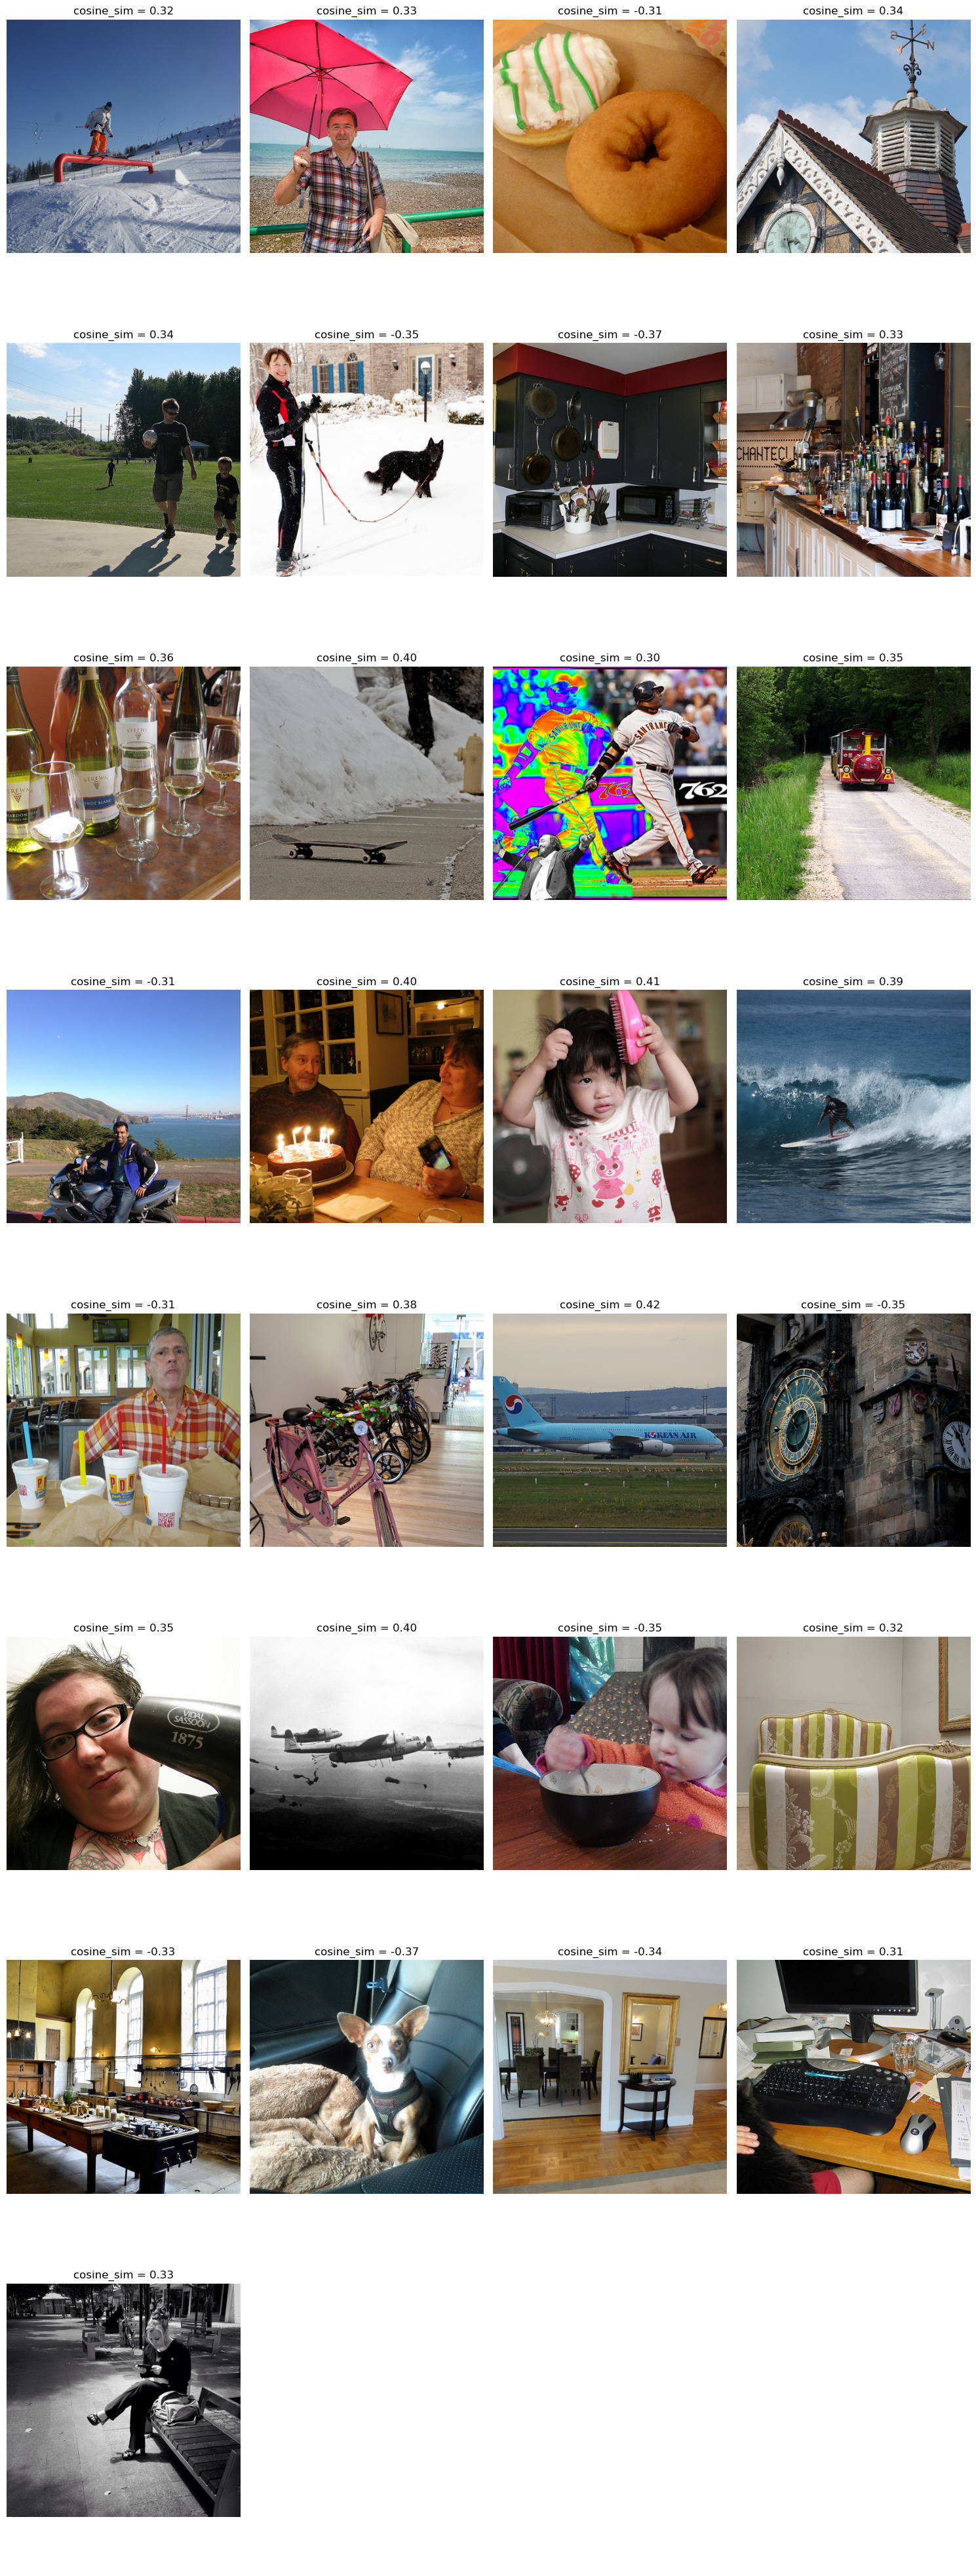

In [51]:
# Display images in a grid of 4 images per row
num_images = len(ic1_subj1_session1)
num_cols = 4
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the required number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.ravel()  # Flatten the axes array for easy iteration

for i, img in enumerate(ic1_subj1_session1):
    # Convert cosine similarity to a scalar
    cos_sim_value = float(cosine_sim_subj1_session1[filtered_indices[i]])  # Ensure it's a scalar
    
    # Display the image in the corresponding grid cell
    axes[i].imshow(img.astype('uint8'))  # Assuming images are in uint8 format
    axes[i].set_title(f"cosine_sim = {cos_sim_value:.2f}")
    axes[i].axis('off')

# Turn off unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [52]:
import gzip
import shutil
import os

# Define the file paths
input_file_path = "/mnt/f_disk/tarak/nsd_data_dump/nsddata_timeseries/ppdata/subj01/func1mm/timeseries/timeseries_session01_run01.nii.gz"
output_file_path = 'subj01_timeseries_session01_run01.nii'  # Removing .gz extension for output

# Check if the file exists and unzip it
if os.path.exists(input_file_path):
    with gzip.open(input_file_path, 'rb') as f_in:
        with open(output_file_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    output_message = f"File successfully extracted to {output_file_path}."
else:
    output_message = "Input file does not exist. Please check the file path."

output_message

'File successfully extracted to subj01_timeseries_session01_run01.nii.'

In [53]:
import nibabel as nib
file_path = "/mnt/f_disk/tarak/fMRI_da/subj01_timeseries_session01_run01.nii"
try:
    nii_data = nib.load(file_path)
    data_array = nii_data.get_fdata()
    header = nii_data.header
    output_message = "File successfully loaded."
except FileNotFoundError:
    data_array = None
    header = None
    output_message = "Input file does not exist. Please check the file path."

output_message, data_array.shape if data_array is not None else None, header

('File successfully loaded.',
 (145, 186, 148, 301),
 <nibabel.nifti1.Nifti1Header at 0x7fc590adc0b0>)

In [54]:
data_array

memmap([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0.

In [55]:
import os
import gzip
import shutil

input_dir = '/mnt/f_disk/tarak/nsd_data_dump/nsddata_timeseries/ppdata/subj01/func1mm/timeseries'
output_dir = '/mnt/f_disk/tarak/fMRI_da/subj01_timeseries_session02'
os.makedirs(output_dir, exist_ok=True)

for n in range(1, 13):
    file_name = f"timeseries_session02_run{n:02d}.nii.gz"
    input_file = os.path.join(input_dir, file_name)
    if os.path.exists(input_file):
        print(f"Unzipping {input_file}...")
        with gzip.open(input_file, 'rb') as f_in:
            output_file = os.path.join(output_dir, file_name[:-3])
            with open(output_file, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"Extracted to {output_file}")
    else:
        print(f"{input_file} does not exist, skipping.")

Unzipping /mnt/f_disk/tarak/nsd_data_dump/nsddata_timeseries/ppdata/subj01/func1mm/timeseries/timeseries_session02_run01.nii.gz...
Extracted to /mnt/f_disk/tarak/fMRI_da/subj01_timeseries_session02/timeseries_session02_run01.nii
Unzipping /mnt/f_disk/tarak/nsd_data_dump/nsddata_timeseries/ppdata/subj01/func1mm/timeseries/timeseries_session02_run02.nii.gz...
Extracted to /mnt/f_disk/tarak/fMRI_da/subj01_timeseries_session02/timeseries_session02_run02.nii
Unzipping /mnt/f_disk/tarak/nsd_data_dump/nsddata_timeseries/ppdata/subj01/func1mm/timeseries/timeseries_session02_run03.nii.gz...
Extracted to /mnt/f_disk/tarak/fMRI_da/subj01_timeseries_session02/timeseries_session02_run03.nii
Unzipping /mnt/f_disk/tarak/nsd_data_dump/nsddata_timeseries/ppdata/subj01/func1mm/timeseries/timeseries_session02_run04.nii.gz...
Extracted to /mnt/f_disk/tarak/fMRI_da/subj01_timeseries_session02/timeseries_session02_run04.nii
Unzipping /mnt/f_disk/tarak/nsd_data_dump/nsddata_timeseries/ppdata/subj01/func1mm/t

In [56]:
import nibabel as nib
output_dir = '/mnt/f_disk/tarak/fMRI_da/subj01_timeseries_session01'
data_array = []

for n in range(1, 13):
    file_name = f"timeseries_session01_run{n:02d}.nii.gz"
    output_file = os.path.join(output_dir, file_name[:-3])
    try:
        nii_data = nib.load(output_file)
        data = nii_data.get_fdata()
        data_array.append(data)
        header = nii_data.header
        output_message = "File successfully loaded."
    except FileNotFoundError:
        data_array = None
        header = None
        output_message = "Input file does not exist. Please check the file path."

In [57]:
len(data_array)

12

In [58]:
ts = []
coords = [70, 45, 21]

for i in range(0, 12):
    ts.append(data_array[i][coords[0], coords[1], coords[2], :])

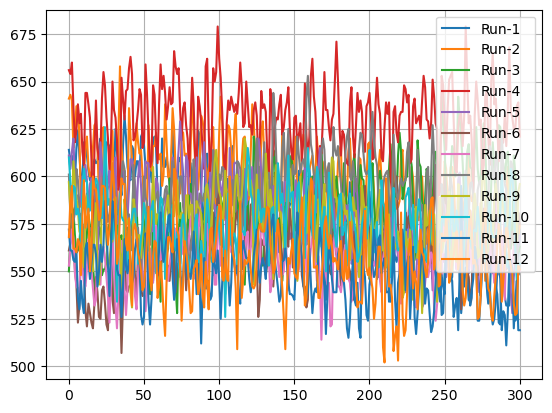

In [59]:
plt.figure()

for i in range(0, 12):
# i = 10
    plt.plot(ts[i], label=f"Run-{i+1}")

plt.grid(True)
plt.legend()
plt.show()

In [60]:
import pandas as pd

c = 0
for i in range(1, 13):
    df = pd.read_csv(f'/mnt/f_disk/tarak/nsd_data_dump/nsddata_timeseries/ppdata/subj01/func1mm/design/design_session01_run{i:02d}.tsv', header=None)
    arr = df[0].values
    print((arr != 0).sum())
    c += (arr != 0).sum()

63
62
63
62
63
62
63
62
63
62
63
62


In [61]:
c

750